In [1]:
#Кумакешв Ф.В. @wewastetimefaded ТФэ-01-21 
#Homework4

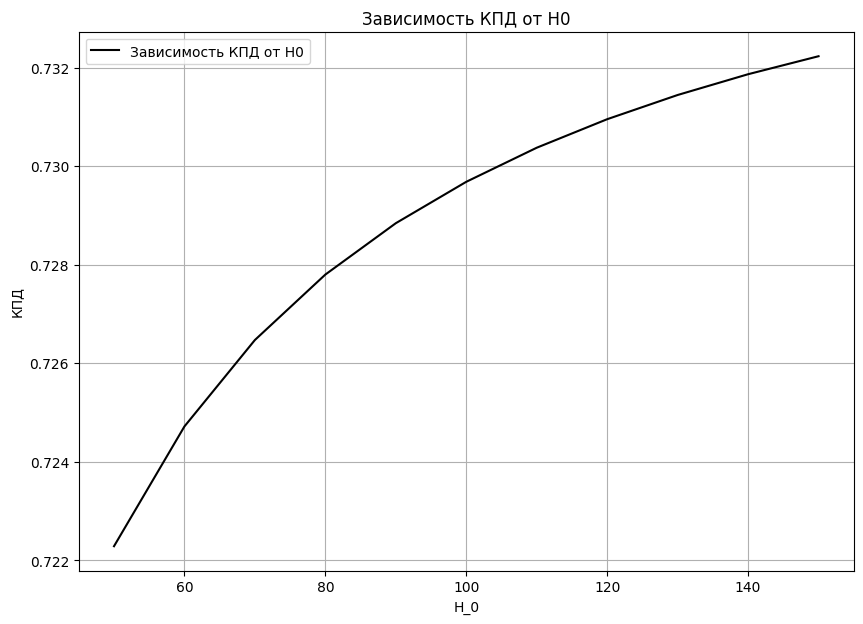

In [6]:
import matplotlib.pyplot as plt
import iapws
from iapws import IAPWS97 as gas

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

H_0 = list (range (50,151,10)) #Интервал 10
H0 = [] 
for value in H_0: 
    result = value * 1000
    H0.append(result)
p = 5 * MPa
t = to_kelvin(489)
blade_efficiency = 0.78
u = 160 
F1 = 0.025
d_r = 1.09
s_div_r = 0.2

DUMMY_SPEED = []
for h0 in H0:
    dummy_speed = (2*h0)**0.5
    DUMMY_SPEED.append(dummy_speed)
u_div_dummy_speed = []
for DS in DUMMY_SPEED:
    u_DIV_dummy_speed = u/DS
    u_div_dummy_speed.append(u_DIV_dummy_speed)

point = gas(P=p * unit, T=t)
kinematic_viscosity = point.nu
Re_number = u * d_r * 0.5 / kinematic_viscosity
def get_k_frictions(s_div_r, re):
    return 2.5 * 10 ** (-2) * s_div_r ** 0.1 * re **(-0.2)
k_frictions = get_k_frictions(s_div_r, Re_number)
k_frictions

def get_friction_loss_pu(k, d, u_div_dummy_speed, F):
    return k * d ** 2 * u_div_dummy_speed ** 3 / F

friction_loss_pu=[]
for UDDS in u_div_dummy_speed:
    friction_loss_pu1 = get_friction_loss_pu(k_frictions, d_r, UDDS, F1)
    friction_loss_pu.append(friction_loss_pu1)

e1 = 0.8
sin_alpha_1 = 0.225
segments = 4
blade_width = 0.035
blade_length = 0.035
m1 = 1
k1 = 0.065

def get_ventilation_loss_pu(m, k, sin, e, u_div_dummy_speed):
    first = k / sin
    second = (1 - e) / e
    third = u_div_dummy_speed ** 3
    return first * second * third * m

ventilation_loss_pu=[]
for UDDS in u_div_dummy_speed:
    ventilation_loss_pu1 = get_ventilation_loss_pu(m1,k1,e1,UDDS,sin_alpha_1)
    ventilation_loss_pu.append(ventilation_loss_pu1)

def get_segment_loss_pu(B, l, F, u_div_dummy_speed, blade_efficiency, segments):
    first = 0.25 * B * l / F
    second = u_div_dummy_speed * blade_efficiency * segments
    return first * second

segment_loss_pu=[]
for UDDS in u_div_dummy_speed:
    segment_loss_pu1 = get_segment_loss_pu(blade_width,blade_length,F1,UDDS,blade_efficiency,segments)
    segment_loss_pu.append(segment_loss_pu1)

partial_losses_pu = [a+b for a,b in zip(ventilation_loss_pu,segment_loss_pu)]

degree_of_reaction = 0.1
z_bandage = 2
delta_r_bandage = 1.17 / 1000
delta_r_bandage / 0.004
delta_a_bandage = 4 / 1000
z_rotor = 5
d_leak_rotor = 0.36
delta_leak_rotor = 0.4 / 1000

delta_r_bandage / 0.004

def compute_equal_gap(z, delta_r, mu_r, delta_a, mu_a):
    first = 1 / (mu_a * delta_a) ** 2
    second = z / (mu_r * delta_r) ** 2
    return (first + second) ** (-0.5)

mu_a = 0.5
mu_r = 0.8
delta_eq_bandage = compute_equal_gap(z_bandage, delta_r_bandage, mu_r, delta_a_bandage, mu_a)
delta_eq_bandage

import math
def get_bandage_leak_loss_pu(d_shroud, delta_eq, F, dor, l, efficiency):
    d_avg = d_shroud - l
    first = math.pi * d_shroud * delta_eq / F
    second = dor + 1.8 * (l / d_avg)
    return first * (second) ** 0.5 * efficiency

d_shroud = delta_r_bandage / 0.001 # По определению задачи
bandage_leak_loss_pu = get_bandage_leak_loss_pu(d_shroud,delta_eq_bandage,F1,degree_of_reaction,blade_length,blade_efficiency)
bandage_leak_loss_pu

F_leak_rotor = math.pi * d_leak_rotor * delta_leak_rotor
F_leak_rotor

# Примем, что диафрагменное уплотнение ступенчатое, т.е. Kу = 1
K_y = 1

# По графику mu = f(зазор / толщина усика) определим при delta_leak_rotor / 0.004 ~ 0.1.
# Возьмем квадратное уплотнение
mu_r_rotor = 0.8

# Примем коэффициент расхода сопловой решетки 0.97
mu_nozzle = 0.97

def get_disk_leak_loss_pu(K, F, mu_r, mu_nozzle, F_nozzle, z, efficiency):
    upper = mu_r * K * F * efficiency
    lower = mu_nozzle * F_nozzle * z ** 0.5
    return upper / lower

disk_leak_loss_pu = get_disk_leak_loss_pu(K_y,F_leak_rotor,mu_r_rotor,mu_nozzle,F1,z_rotor,blade_efficiency)

leak_losses_pu = disk_leak_loss_pu + bandage_leak_loss_pu

Sum_FLP_and_PLP = [a+b for a,b in zip(friction_loss_pu,partial_losses_pu)]

internal_efficiency=[]
for SUM in Sum_FLP_and_PLP:
    internal_efficiency1 = blade_efficiency - SUM - leak_losses_pu
    internal_efficiency.append(internal_efficiency1)

fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.plot(H_0,internal_efficiency, label="Зависимость КПД от H0",color='Black')
ax.set_title("Зависимость КПД от H0")
ax.set_xlabel("H_0")
ax.set_ylabel("КПД")
ax.grid()
ax.legend();